# SETUP

In [1]:
import os
os.getcwd()
os.chdir("..")

In [2]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from kneed import KneeLocator
from plotnine import *
from ttictoc import tic,toc
from datetime import date
import itertools

In [3]:
pd.options.display.max_rows = 10
pd.options.display.max_columns = 999999

# UDFs

In [4]:
def draw_line_plot_for_each_k(df, x_var, y_var):
    """Make a line plot using ggplot grammar of graphics

    Args:
        df (data.frame): dataset
        x_var (string): name of variable for x axis
        y_var (string): name of variable for y axis

    Yields:
        plot: Line plot with also marked points

    Examples:
        >>> draw_line_plot_for_each_k(dataset, "nb_clusters", "error")
    """
    return (ggplot(df) +
     geom_line(aes(x = x_var, y = y_var)) +
     geom_point(aes(x = x_var, y = y_var)) +
     ggtitle(y_var + " for selected k") + 
     theme_light() + 
     scale_x_continuous(breaks = df[x_var]))

def highlight_elbow_row(df, elbow, column):
    """Return dataframe containing cluster stats with highlighted selected number of clusters

    Args:
        df (data.frame): dataset with clustering stats
        elbow (int): selected number of clusters
        column (string): name of variable containing number of clusters

    Yields:
        plot: formatted data frame

    Examples:
        >>> data.style.apply(highlight_elbow_row, elbow = 5, column = 'nb_clusters', axis=1)
    """
    is_selected = pd.Series(data = False, index = df.index)
    is_selected[column] = (df.loc[column] >= elbow) & (df.loc[column] <= (elbow))
    return ['background-color: green' if is_selected.any() else '' for v in is_selected]

def mapping_marital_status(x):
    """Return two series 1) informing how many adults live in given household and 2) with simplified marital status

    Args:
        x (data.serie): variable with marital status

    Yields:
        data.frame: with two series

    Examples:
        >>> df[['adults', 'marital_status_cleaned']] = df['marital_status'].apply(lambda x: mapping_marital_status(x)).to_list()
    """
    if x in ['Single', 'Divorced', 'Widow', 'Alone']:
        val_num = 1.0
        val_verb = "single"
    elif x in ['Together', 'Married']:
        val_num = 2.0
        val_verb = "in couple"
    else:
        val_num = np.nan
        val_verb = "unknown"
    return [val_num, val_verb]


def plot_boxplot_by_cluster(df, num_var, cluster_var):
    return print(ggplot(df) + 
          geom_boxplot(aes(x = cluster_var, y = num_var, fill = cluster_var)) +
             ggtitle(num_var) + 
          theme_light())
    """Make a box plot for each cluster using ggplot grammar of graphics

    Args:
        df (data.frame): dataset
        num_var (string): name of numeric variable for density estimation
        cluster_var (string): name of variable with clustes

    Yields:
        plot: Density plot for distributions from all clusters

    Examples:
        >>> plot_boxplot_by_cluster(dataset, "age", "cluster_kmeans")
    """
    
def plot_scatter_by_cluster(df, num_var1, num_var2, cluster_var):
    return print(ggplot(df) +
                 geom_point(aes(x = num_var1, y = num_var2, color = cluster_var)) + 
                 ggtitle(num_var1 + " vs " + num_var2) + 
                 theme_light())
    """Make a scatter plot colored by clusters using ggplot grammar of graphics

    Args:
        df (data.frame): dataset
        num_var1 (string): name of variable for x axis
        num_var2 (string): name of variable for y axis
        cluster_var (string): name of variable with clustes

    Yields:
        plot: Density plot with overlaping distributions

    Examples:
        >>> plot_scatter_by_cluster(dataset, "age", "total_purchases", "cluster_kmeans")
    """

# Data load

In [5]:
df = pd.read_csv("data/raw/marketing_campaign.csv", sep = "\t")
df.columns = df.columns.str.lower()
print(df.shape)
df.head()

(2240, 29)


,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,acceptedcmp3,acceptedcmp4,acceptedcmp5,acceptedcmp1,acceptedcmp2,complain,z_costcontact,z_revenue,response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


## Profiling report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\Winter\anaconda3\envs\customer-segmentation\lib\site-packages\missingno\missingno.py:254: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\Winter\anaconda3\envs\customer-segmentation\lib\site-packages\pandas_profiling\model\missing.py:89: UserWarning: There was an attempt to generate the Count missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(missing_diagrams={"Count": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (53).')


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

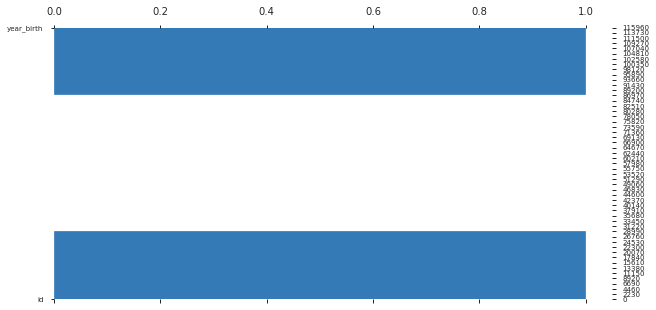

In [43]:
pandas_profiling_raw = ProfileReport(df, title = "Report - pandas_profiling - raw dataset")
#pandas_profiling_raw.to_notebook_iframe()
pandas_profiling_raw.to_file("reports/Report pandas-profiler - raw data.html")

# Feature engineering

Fixing column types

In [7]:
df['kidhome'] = df['kidhome'].astype('int')
df['teenhome'] = df['teenhome'].astype('int')
df['dt_customer'] = pd.to_datetime(df['dt_customer'], format = "%d-%m-%Y")
df['acceptedcmp1'] = df['acceptedcmp1'].astype('int')
df['acceptedcmp2'] = df['acceptedcmp2'].astype('int')
df['acceptedcmp3'] = df['acceptedcmp3'].astype('int')
df['acceptedcmp4'] = df['acceptedcmp4'].astype('int')
df['acceptedcmp5'] = df['acceptedcmp5'].astype('int')
df['complain'] = df['complain'].astype('int')
df['response'] = df['response'].astype('int')

Columns and rows removal, NA inputation

In [8]:
df = df.drop(columns = ["z_costcontact", "z_revenue"], axis = 1)
df['income'] = df['income'].fillna(df['income'].median())
df = df.loc[~df.marital_status.isin(['Absurd', 'YOLO'])]

Creation of new features

In [9]:
df['age'] = date.today().year - df['year_birth']
df['nb_kids'] = df['kidhome'] + df['teenhome']
df["is_parent"] = np.where(df.nb_kids > 0, 1, 0)
df[['adults', 'marital_status_cleaned']] = df['marital_status'].apply(lambda x: mapping_marital_status(x)).to_list()
df['nb_family_members'] = df['nb_kids'] + df['adults']
df["nb_family_members"] = df["nb_family_members"].astype(int)
df['education_cleaned'] = df['education'].replace({'Basic':'Undergraduate','2n Cycle':'Undergraduate','Graduation':'Postgraduate','Master':'Postgraduate','PhD':'Postgraduate'})
df['marital_status'] = df['marital_status'].replace({'Divorced':'Alone','Single':'Alone','Married':'In couple','Together':'In couple','Absurd':'unknown','Widow':'Alone','YOLO':'unknown'})
df['income_per_person'] = (df['income'] / df['nb_family_members'])
df["income_per_person"] = df["income_per_person"].astype(int)
df['tenure_days'] = pd.to_datetime(date.today(), format = "%Y-%m-%d") - df['dt_customer']
df['tenure_days'] = df['tenure_days'].dt.days
df['total_spendings'] = df['mntwines'] + df['mntfruits'] + df['mntmeatproducts'] + df['mntfishproducts'] + df['mntsweetproducts'] + df['mntgoldprods'] 
df["total_spendings"] = df["total_spendings"].astype(int)
df['wines_share'] = df['mntwines'] / df['total_spendings']
df['fruits_share'] = df['mntfruits'] / df['total_spendings']
df['meat_share'] = df['mntmeatproducts'] / df['total_spendings']
df['fish_share'] = df['mntfishproducts'] / df['total_spendings']
df['sweets_share'] = df['mntsweetproducts'] / df['total_spendings']
df['gold_products_share'] = df['mntgoldprods'] / df['total_spendings']
df['total_spendings_per_person'] = (df['total_spendings'] / df['nb_family_members'])
df["total_spendings_per_person"] = df["total_spendings_per_person"].astype(int)
df["nb_accepted_campaigns"] = df[["acceptedcmp1", "acceptedcmp2", "acceptedcmp3", "acceptedcmp4", "acceptedcmp5"]].gt(0).sum(axis = 1)
df["total_purchases"] = df["numwebpurchases"] + df["numcatalogpurchases"] + df["numstorepurchases"]
df["total_spendings_per_purchase"] = (df['total_spendings'] / df["total_purchases"])
df["total_spendings_per_purchase"] = df["total_spendings_per_purchase"]
df["spendings_to_income"] = df['total_spendings'] / df['income']
df["pct_deals_purchases"] = df["numdealspurchases"] / df["total_purchases"]
df["pct_web_purchasess"] = df["numwebpurchases"] / df["total_purchases"]
df["pct_catalog_purchases"] = df["numcatalogpurchases"] / df["total_purchases"]
df["pct_store_purchases"] = df["numstorepurchases"] / df["total_purchases"]

In [10]:
df["total_spendings_per_purchase"].describe()

count    2236.000000
mean             inf
std              NaN
min         2.666667
25%        13.000000
50%        29.839744
75%        50.015468
max              inf
Name: total_spendings_per_purchase, dtype: float64

Final cleaning

In [11]:
df = df.loc[~((df.total_spendings > 0) & (df.total_purchases == 0)),:]
df = df.set_index('id')

In [12]:
df.head()

,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,acceptedcmp3,acceptedcmp4,acceptedcmp5,acceptedcmp1,acceptedcmp2,complain,response,age,nb_kids,is_parent,adults,marital_status_cleaned,nb_family_members,education_cleaned,income_per_person,tenure_days,total_spendings,wines_share,fruits_share,meat_share,fish_share,sweets_share,gold_products_share,total_spendings_per_person,nb_accepted_campaigns,total_purchases,total_spendings_per_purchase,spendings_to_income,pct_deals_purchases,pct_web_purchasess,pct_catalog_purchases,pct_store_purchases
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Alone,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,65,0,0,1.0,single,1,Postgraduate,58138,3612,1617,0.392703,0.054422,0.337662,0.106370,0.054422,0.054422,1617,0,22,73.500000,0.027813,0.136364,0.363636,0.454545,0.181818
2174,1954,Graduation,Alone,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,68,2,1,1.0,single,3,Postgraduate,15448,3062,27,0.407407,0.037037,0.222222,0.074074,0.037037,0.222222,9,0,4,6.750000,0.000583,0.500000,0.250000,0.250000,0.500000
4141,1965,Graduation,In couple,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,57,0,0,2.0,in couple,2,Postgraduate,35806,3261,776,0.548969,0.063144,0.163660,0.143041,0.027062,0.054124,388,0,20,38.800000,0.010836,0.050000,0.400000,0.100000,0.500000
6182,1984,Graduation,In couple,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,38,1,1,2.0,in couple,3,Postgraduate,8882,3088,53,0.207547,0.075472,0.377358,0.188679,0.056604,0.094340,17,0,6,8.833333,0.001989,0.333333,0.333333,0.000000,0.666667
5324,1981,PhD,In couple,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,41,1,1,2.0,in couple,3,Postgraduate,19431,3110,422,0.409953,0.101896,0.279621,0.109005,0.063981,0.035545,140,0,14,30.142857,0.007239,0.357143,0.357143,0.214286,0.428571


## Profiling report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\Winter\anaconda3\envs\customer-segmentation\lib\site-packages\missingno\missingno.py:254: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\Winter\anaconda3\envs\customer-segmentation\lib\site-packages\pandas_profiling\model\missing.py:89: UserWarning: There was an attempt to generate the Count missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(missing_diagrams={"Count": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (53).')


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

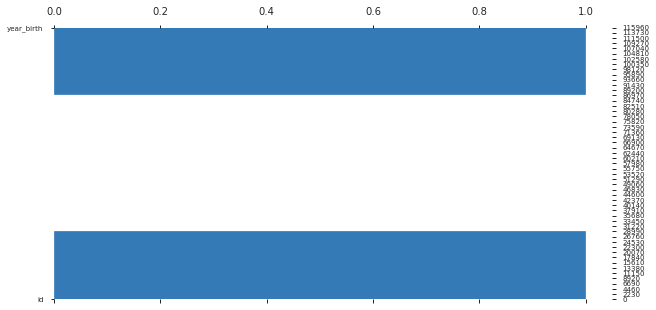

In [42]:
pandas_profiling_extended = ProfileReport(df, title = "Report - pandas_profiling - extended")
#pandas_profiling_extended.to_notebook_iframe()
pandas_profiling_extended.to_file("reports/Report pandas-profiler - extended data.html")

## Features selection and data preprocessing

In [14]:
num_features_to_scale = ["age", "tenure_days",
                         "recency", "income_per_person", "total_spendings", "total_spendings_per_person", "total_spendings_per_purchase",
                         "numwebvisitsmonth", "total_purchases",
                         "spendings_to_income"]

other_num_features = ["is_parent", "nb_family_members", 
                      "wines_share", "fruits_share", "meat_share", "fish_share", "sweets_share", "gold_products_share",
                      "pct_deals_purchases", "pct_web_purchasess", "pct_catalog_purchases", "pct_store_purchases",
                      "complain", "response", "nb_accepted_campaigns"]

cat_features = ["marital_status_cleaned", "education_cleaned"]

### Numeric features required scaling

In [15]:
df_num_to_scale = df.loc[:, num_features_to_scale]
df_num_to_scale.describe()

,age,tenure_days,recency,income_per_person,total_spendings,total_spendings_per_person,total_spendings_per_purchase,numwebvisitsmonth,total_purchases,spendings_to_income
count,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000
mean,53.195964,3302.863677,49.128700,24870.200448,607.046188,326.667713,38.183781,5.301794,12.565022,0.009925
std,11.987345,201.899680,28.963987,19611.285378,602.516120,431.469158,45.958297,2.370930,7.190046,0.016790
min,26.000000,2949.000000,0.000000,815.000000,8.000000,1.000000,2.666667,0.000000,1.000000,0.000093
25%,45.000000,3130.250000,24.000000,12184.250000,69.000000,24.000000,13.000000,3.000000,6.000000,0.002344
50%,52.000000,3305.000000,49.000000,18594.500000,396.500000,144.000000,29.688095,6.000000,12.000000,0.007973
75%,63.000000,3477.750000,74.000000,31916.750000,1046.500000,480.750000,49.156250,7.000000,18.000000,0.015535
max,129.000000,3648.000000,99.000000,222222.000000,2525.000000,2525.000000,1679.000000,20.000000,32.000000,0.706988


In [16]:
#outliers imputation
suspicious_num_vas = ['age', 'total_spendings', 'total_spendings_per_purchase']
df_num_to_scale[suspicious_num_vas] = df_num_to_scale[suspicious_num_vas].apply(lambda x: x.clip(*x.quantile([0.00, 0.99])))
df_num_to_scale.describe()

,age,tenure_days,recency,income_per_person,total_spendings,total_spendings_per_person,total_spendings_per_purchase,numwebvisitsmonth,total_purchases,spendings_to_income
count,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000
mean,53.118386,3302.863677,49.128700,24870.200448,605.273991,326.667713,37.301930,5.301794,12.565022,0.009925
std,11.700018,201.899680,28.963987,19611.285378,597.637945,431.469158,29.435469,2.370930,7.190046,0.016790
min,26.000000,2949.000000,0.000000,815.000000,8.000000,1.000000,2.666667,0.000000,1.000000,0.000093
25%,45.000000,3130.250000,24.000000,12184.250000,69.000000,24.000000,13.000000,3.000000,6.000000,0.002344
50%,52.000000,3305.000000,49.000000,18594.500000,396.500000,144.000000,29.688095,6.000000,12.000000,0.007973
75%,63.000000,3477.750000,74.000000,31916.750000,1046.500000,480.750000,49.156250,7.000000,18.000000,0.015535
max,77.000000,3648.000000,99.000000,222222.000000,2126.000000,2525.000000,128.626000,20.000000,32.000000,0.706988


In [17]:
df_scaled_num_features = df_num_to_scale.copy()

for i in df_scaled_num_features.columns:
    df_scaled_num_features.loc[:, i] = StandardScaler().fit_transform(np.array(df_scaled_num_features[[i]]))

df_scaled_num_features.describe()

,age,tenure_days,recency,income_per_person,total_spendings,total_spendings_per_person,total_spendings_per_purchase,numwebvisitsmonth,total_purchases,spendings_to_income
count,2.230000e+03,2.230000e+03,2.230000e+03,2.230000e+03,2.230000e+03,2.230000e+03,2.230000e+03,2.230000e+03,2.230000e+03,2.230000e+03
mean,2.712330e-16,3.405348e-17,7.136792e-17,1.389023e-17,5.790087e-17,-1.657867e-17,1.039029e-16,2.436019e-16,8.871827e-17,9.036120e-18
std,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00
min,-2.318327e+00,-1.753064e+00,-1.696580e+00,-1.226875e+00,-9.996152e-01,-7.549572e-01,-1.176915e+00,-2.236668e+00,-1.608838e+00,-5.857038e-01
25%,-6.940337e-01,-8.551395e-01,-8.677789e-01,-6.470150e-01,-8.975238e-01,-7.016390e-01,-8.257854e-01,-9.710580e-01,-9.132758e-01,-4.516047e-01
50%,-9.560981e-02,1.058348e-02,-4.444430e-03,-3.200763e-01,-3.494102e-01,-4.234571e-01,-2.587199e-01,2.945524e-01,-7.860161e-02,-1.162453e-01
75%,8.447706e-01,8.663983e-01,8.588900e-01,3.593915e-01,7.384487e-01,3.571909e-01,4.028126e-01,7.164225e-01,7.560726e-01,3.342547e-01
max,2.041618e+00,1.709828e+00,1.722224e+00,1.006543e+01,2.545131e+00,5.096136e+00,3.103214e+00,6.200734e+00,2.703646e+00,4.152644e+01


### Other numeric features - that do not require scaling

In [18]:
df_other_num = df.loc[:, other_num_features]
df_other_num.describe()

,is_parent,nb_family_members,wines_share,fruits_share,meat_share,fish_share,sweets_share,gold_products_share,pct_deals_purchases,pct_web_purchasess,pct_catalog_purchases,pct_store_purchases,complain,response,nb_accepted_campaigns
count,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000
mean,0.716592,2.599103,0.458770,0.049306,0.249714,0.071379,0.050739,0.120093,0.247970,0.329836,0.164667,0.505497,0.009417,0.148879,0.298206
std,0.450754,0.904998,0.228414,0.055716,0.126671,0.077915,0.061176,0.109194,0.356958,0.121800,0.140553,0.149548,0.096605,0.356049,0.678680
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.290197,0.008949,0.156318,0.012576,0.008637,0.038024,0.083333,0.250000,0.000000,0.401852,0.000000,0.000000,0.000000
50%,1.000000,3.000000,0.457822,0.029710,0.233746,0.048158,0.033333,0.085511,0.200000,0.333333,0.150000,0.500000,0.000000,0.000000,0.000000
75%,1.000000,3.000000,0.639277,0.069739,0.328238,0.103448,0.070291,0.169797,0.333333,0.400000,0.250000,0.600000,0.000000,0.000000,0.000000
max,1.000000,5.000000,0.963303,0.445545,0.997110,0.590909,0.945848,0.894150,15.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


### Categorical features for encoding

In [19]:
df_cat = df.loc[:, cat_features]
df_cat.describe()

,marital_status_cleaned,education_cleaned
count,2230,2230
unique,2,2
top,in couple,Postgraduate
freq,1442,1973


In [20]:
lbl_encode = LabelEncoder()
df_cat_encoded = pd.DataFrame()
for i in cat_features:
    df_cat_encoded[i] = df_cat[[i]].apply(lbl_encode.fit_transform)
df_cat_encoded.describe()

,marital_status_cleaned,education_cleaned
count,2230.000000,2230.000000
mean,0.353363,0.115247
std,0.478121,0.319391
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,1.000000,1.000000


### Joining all preprocessed datasets

In [21]:
df_scaled = df_scaled_num_features.join(df_other_num).join(df_cat_encoded)
print(df.shape)
print(df_scaled.shape)

del df_scaled_num_features, df_other_num, df_cat_encoded
del df_num_to_scale, df_cat

(2230, 51)
(2230, 27)


In [22]:
df_scaled.describe()

,age,tenure_days,recency,income_per_person,total_spendings,total_spendings_per_person,total_spendings_per_purchase,numwebvisitsmonth,total_purchases,spendings_to_income,is_parent,nb_family_members,wines_share,fruits_share,meat_share,fish_share,sweets_share,gold_products_share,pct_deals_purchases,pct_web_purchasess,pct_catalog_purchases,pct_store_purchases,complain,response,nb_accepted_campaigns,marital_status_cleaned,education_cleaned
count,2.230000e+03,2.230000e+03,2.230000e+03,2.230000e+03,2.230000e+03,2.230000e+03,2.230000e+03,2.230000e+03,2.230000e+03,2.230000e+03,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000
mean,2.712330e-16,3.405348e-17,7.136792e-17,1.389023e-17,5.790087e-17,-1.657867e-17,1.039029e-16,2.436019e-16,8.871827e-17,9.036120e-18,0.716592,2.599103,0.458770,0.049306,0.249714,0.071379,0.050739,0.120093,0.247970,0.329836,0.164667,0.505497,0.009417,0.148879,0.298206,0.353363,0.115247
std,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,0.450754,0.904998,0.228414,0.055716,0.126671,0.077915,0.061176,0.109194,0.356958,0.121800,0.140553,0.149548,0.096605,0.356049,0.678680,0.478121,0.319391
min,-2.318327e+00,-1.753064e+00,-1.696580e+00,-1.226875e+00,-9.996152e-01,-7.549572e-01,-1.176915e+00,-2.236668e+00,-1.608838e+00,-5.857038e-01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.940337e-01,-8.551395e-01,-8.677789e-01,-6.470150e-01,-8.975238e-01,-7.016390e-01,-8.257854e-01,-9.710580e-01,-9.132758e-01,-4.516047e-01,0.000000,2.000000,0.290197,0.008949,0.156318,0.012576,0.008637,0.038024,0.083333,0.250000,0.000000,0.401852,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-9.560981e-02,1.058348e-02,-4.444430e-03,-3.200763e-01,-3.494102e-01,-4.234571e-01,-2.587199e-01,2.945524e-01,-7.860161e-02,-1.162453e-01,1.000000,3.000000,0.457822,0.029710,0.233746,0.048158,0.033333,0.085511,0.200000,0.333333,0.150000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.447706e-01,8.663983e-01,8.588900e-01,3.593915e-01,7.384487e-01,3.571909e-01,4.028126e-01,7.164225e-01,7.560726e-01,3.342547e-01,1.000000,3.000000,0.639277,0.069739,0.328238,0.103448,0.070291,0.169797,0.333333,0.400000,0.250000,0.600000,0.000000,0.000000,0.000000,1.000000,0.000000
max,2.041618e+00,1.709828e+00,1.722224e+00,1.006543e+01,2.545131e+00,5.096136e+00,3.103214e+00,6.200734e+00,2.703646e+00,4.152644e+01,1.000000,5.000000,0.963303,0.445545,0.997110,0.590909,0.945848,0.894150,15.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


# K-means 

## Analysis of errors for selected k

In [23]:
df_sse = pd.DataFrame({"nb_clusters": list(range(1, 11))})

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42
}

for k in df_sse.nb_clusters:
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs).fit(df_scaled)
    df_sse.loc[k - 1, 'sse'] = kmeans.inertia_
    if k > 1:
        df_sse.loc[k - 1, 'dbs'] = davies_bouldin_score(df_scaled, kmeans.labels_)
        df_sse.loc[k - 1, 'silhouette'] = silhouette_score(df_scaled, kmeans.labels_)

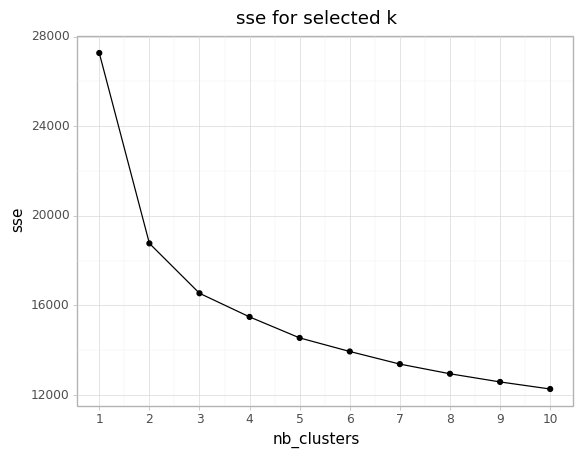

<ggplot: (128484108430)>

In [24]:
draw_line_plot_for_each_k(df_sse, "nb_clusters", "sse")

C:\Users\Winter\anaconda3\envs\customer-segmentation\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
C:\Users\Winter\anaconda3\envs\customer-segmentation\lib\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


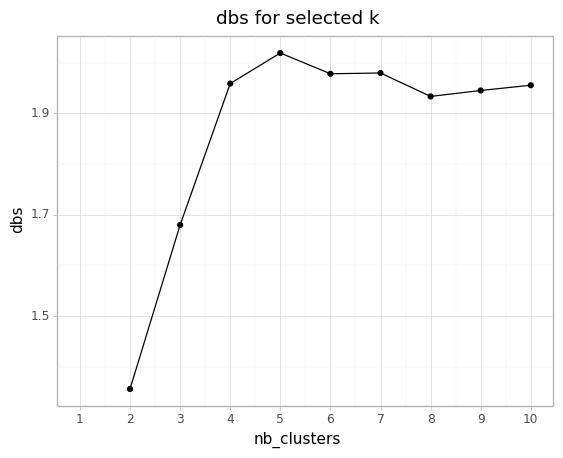

<ggplot: (128484220853)>

In [25]:
draw_line_plot_for_each_k(df_sse, "nb_clusters", "dbs")

C:\Users\Winter\anaconda3\envs\customer-segmentation\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
C:\Users\Winter\anaconda3\envs\customer-segmentation\lib\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


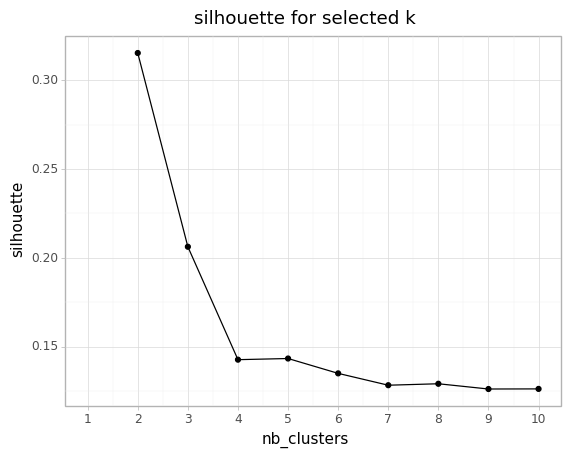

<ggplot: (128484153772)>

In [26]:
draw_line_plot_for_each_k(df_sse, "nb_clusters", "silhouette")

Elbow detection

In [27]:
kl = KneeLocator(df_sse.nb_clusters, df_sse.sse, curve = "convex", direction = "decreasing")
kl.elbow

3

In [28]:
df_sse.style.apply(highlight_elbow_row, elbow = kl.elbow, column = 'nb_clusters', axis=1)

,nb_clusters,sse,dbs,silhouette
0,1,27263.881797,nan,nan
1,2,18767.576625,1.356199,0.315317
2,3,16540.754080,1.679871,0.206245
3,4,15485.708360,1.958821,0.142672
4,5,14548.450660,2.019114,0.143323
5,6,13942.825366,1.978167,0.134963
6,7,13379.807703,1.979692,0.128293
7,8,12948.049799,1.933429,0.129113
8,9,12583.794255,1.945216,0.126156
9,10,12268.152145,1.955536,0.126221


## Check if clusters initiation would improve results

In [29]:
kmeans_kwargs_initiated = {
    "init": "k-means++",
    "max_iter": 300
}

for k in list([kl.elbow, kl.elbow + 1]):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs_initiated).fit(df_scaled)
    df_sse.loc[k - 1, 'sse_centers_init'] = kmeans.inertia_
    if k > 1:
        df_sse.loc[k - 1, 'dbs_centers_init'] = davies_bouldin_score(df_scaled, kmeans.labels_)
        df_sse.loc[k - 1, 'silhouette_centers_init'] = silhouette_score(df_scaled, kmeans.labels_)

In [30]:
final_nb_clusters = kl.elbow
df_sse.style.apply(highlight_elbow_row, elbow = final_nb_clusters, column = 'nb_clusters', axis=1)

,nb_clusters,sse,dbs,silhouette,sse_centers_init,dbs_centers_init,silhouette_centers_init
0,1,27263.881797,nan,nan,nan,nan,nan
1,2,18767.576625,1.356199,0.315317,nan,nan,nan
2,3,16540.754080,1.679871,0.206245,16540.712009,1.679934,0.206165
3,4,15485.708360,1.958821,0.142672,14847.060926,1.272948,0.208137
4,5,14548.450660,2.019114,0.143323,nan,nan,nan
5,6,13942.825366,1.978167,0.134963,nan,nan,nan
6,7,13379.807703,1.979692,0.128293,nan,nan,nan
7,8,12948.049799,1.933429,0.129113,nan,nan,nan
8,9,12583.794255,1.945216,0.126156,nan,nan,nan
9,10,12268.152145,1.955536,0.126221,nan,nan,nan


## Hierarchical clustering to initialize clusters

### IMPORTANT!: can be used only for small datasets!

Initial clusters computations using hierarchical clustering results

In [31]:
cluster_initials = df_scaled.copy()
hierarchical_clust = AgglomerativeClustering(n_clusters = final_nb_clusters).fit(cluster_initials)

cluster_initials["hierarchical_cluster"] = hierarchical_clust.fit_predict(cluster_initials)
cluster_initials = cluster_initials.groupby(['hierarchical_cluster'], as_index=False, sort=False).mean()
cluster_initials = cluster_initials.drop("hierarchical_cluster", axis = 1)
cluster_initials

,age,tenure_days,recency,income_per_person,total_spendings,total_spendings_per_person,total_spendings_per_purchase,numwebvisitsmonth,total_purchases,spendings_to_income,is_parent,nb_family_members,wines_share,fruits_share,meat_share,fish_share,sweets_share,gold_products_share,pct_deals_purchases,pct_web_purchasess,pct_catalog_purchases,pct_store_purchases,complain,response,nb_accepted_campaigns,marital_status_cleaned,education_cleaned
0,0.093201,-0.047650,0.037080,1.461240,1.344407,1.504655,1.347699,-1.125485,0.877263,0.599483,0.069530,1.623722,0.445040,0.047305,0.333430,0.069737,0.049144,0.055344,0.064668,0.258783,0.312871,0.428346,0.004090,0.329243,0.828221,0.451943,0.077710
1,-0.130050,-0.056789,-0.013188,-0.559600,-0.737419,-0.614851,-0.665180,0.472571,-0.720446,-0.347476,0.887739,2.926752,0.419883,0.053085,0.235279,0.078358,0.053762,0.159633,0.350839,0.354297,0.089992,0.555712,0.011146,0.095541,0.088376,0.337580,0.143312
2,0.242821,0.195110,-0.003234,-0.024101,0.554192,0.075210,0.363797,-0.089045,0.981234,0.295429,0.925773,2.734021,0.573317,0.041535,0.202690,0.054959,0.044522,0.082978,0.166388,0.338130,0.208626,0.453244,0.010309,0.105155,0.307216,0.294845,0.080412


In [32]:
kmeans_clust_init_hier = KMeans(n_clusters  = final_nb_clusters, init = cluster_initials.to_numpy(), n_init = 1, max_iter = 300).fit(df_scaled)

df_sse.loc[final_nb_clusters - 1, 'sse_centers_init_hier'] = kmeans_clust_init_hier.inertia_
df_sse.loc[final_nb_clusters - 1, 'dbs_centers_init_hier'] = davies_bouldin_score(df_scaled, kmeans_clust_init_hier.labels_)
df_sse.loc[final_nb_clusters - 1, 'silhouette_centers_init_hier'] = silhouette_score(df_scaled, kmeans_clust_init_hier.labels_)

In [33]:
df_sse.style.apply(highlight_elbow_row, elbow = final_nb_clusters, column = 'nb_clusters', axis=1)

,nb_clusters,sse,dbs,silhouette,sse_centers_init,dbs_centers_init,silhouette_centers_init,sse_centers_init_hier,dbs_centers_init_hier,silhouette_centers_init_hier
0,1,27263.881797,nan,nan,nan,nan,nan,nan,nan,nan
1,2,18767.576625,1.356199,0.315317,nan,nan,nan,nan,nan,nan
2,3,16540.754080,1.679871,0.206245,16540.712009,1.679934,0.206165,16540.659248,1.681459,0.205852
3,4,15485.708360,1.958821,0.142672,14847.060926,1.272948,0.208137,nan,nan,nan
4,5,14548.450660,2.019114,0.143323,nan,nan,nan,nan,nan,nan
5,6,13942.825366,1.978167,0.134963,nan,nan,nan,nan,nan,nan
6,7,13379.807703,1.979692,0.128293,nan,nan,nan,nan,nan,nan
7,8,12948.049799,1.933429,0.129113,nan,nan,nan,nan,nan,nan
8,9,12583.794255,1.945216,0.126156,nan,nan,nan,nan,nan,nan
9,10,12268.152145,1.955536,0.126221,nan,nan,nan,nan,nan,nan


Adding cluster variable to core dataset

In [34]:
df["cluster_kmeans"] = kmeans_clust_init_hier.fit_predict(df_scaled)
df["cluster_kmeans"] = df["cluster_kmeans"].astype("category")

Clusters distribution check

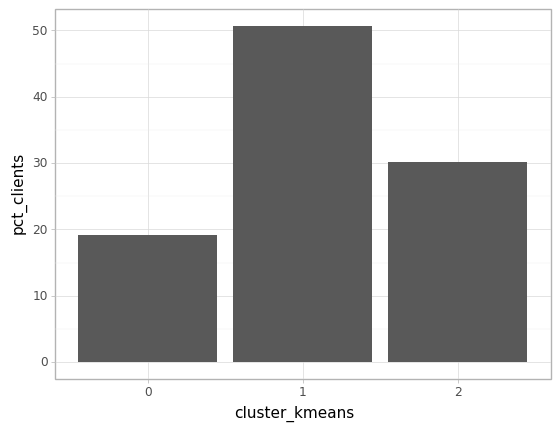

<ggplot: (128483049593)>

In [35]:
tb_cluster_counts = pd.DataFrame(df["cluster_kmeans"].value_counts() / df.shape[0] * 100).reset_index()
tb_cluster_counts.columns = ["cluster_kmeans", "pct_clients"]

(ggplot(tb_cluster_counts) + 
 geom_col(aes(x = "cluster_kmeans", y = "pct_clients")) + 
 theme_light())

# tSNE

### IMPORTANT!: may stuck on big dataset

In [36]:
tic()
tsne = TSNE(n_components = 2, verbose = 0, learning_rate = 'auto',
            init = 'random', random_state = 123)
tsne_fitted = tsne.fit_transform(df_scaled)
toc()

7.914745299999993

In [37]:
df_tSNE = pd.DataFrame()
df_tSNE["cluster_kmeans"] = kmeans_clust_init_hier.fit_predict(df_scaled)
df_tSNE["cluster_kmeans"] = df_tSNE["cluster_kmeans"].astype("category")
df_tSNE["comp-1"] = tsne_fitted[:,0]
df_tSNE["comp-2"] = tsne_fitted[:,1]

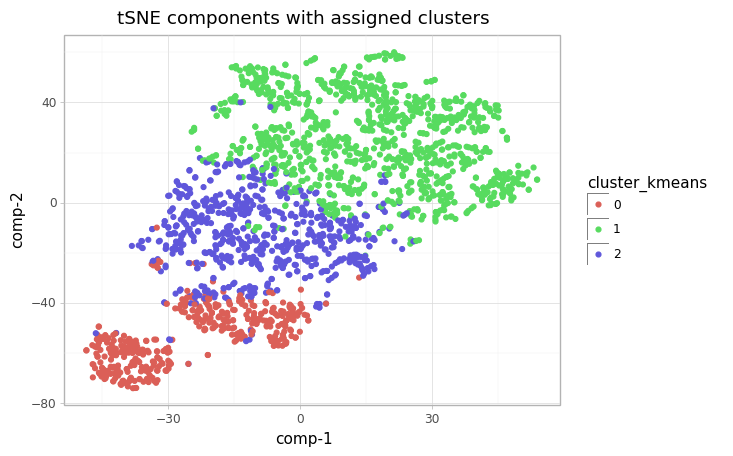

<ggplot: (128488685523)>

In [38]:
(ggplot(df_tSNE) + 
 geom_point(aes(x = "comp-1", y = "comp-2", color = "cluster_kmeans")) + 
 ggtitle("tSNE components with assigned clusters") + 
 theme_light())

## Profiling

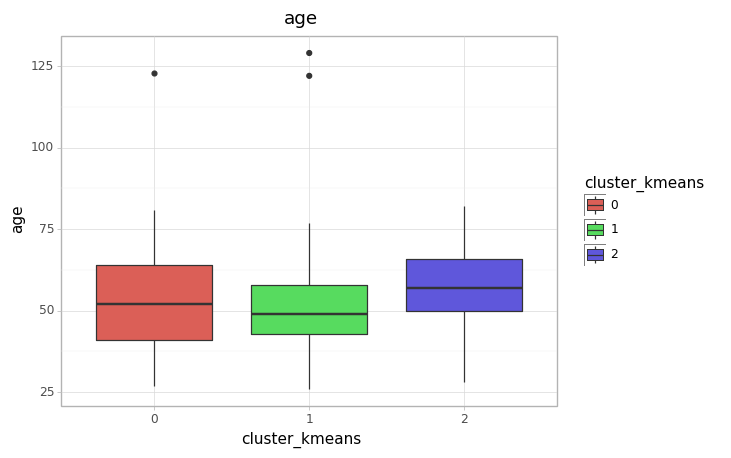

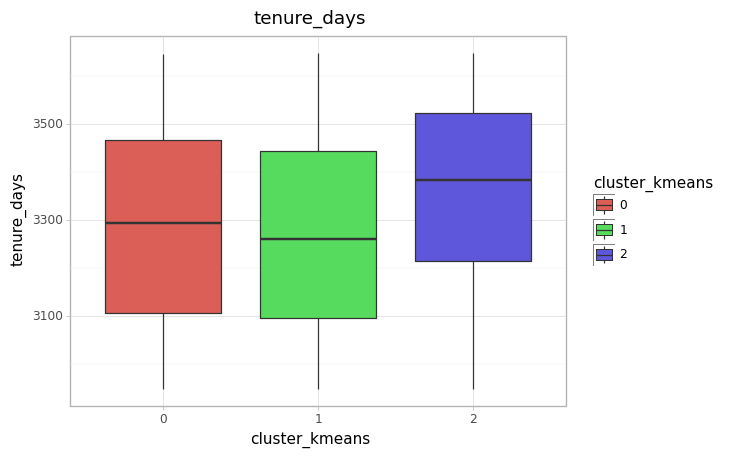

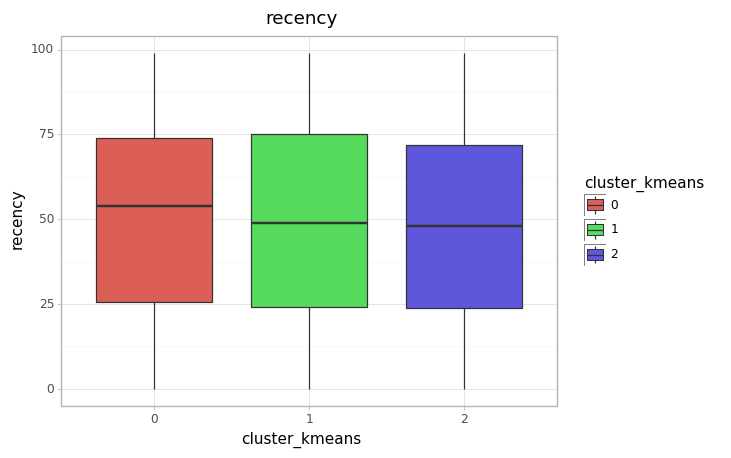

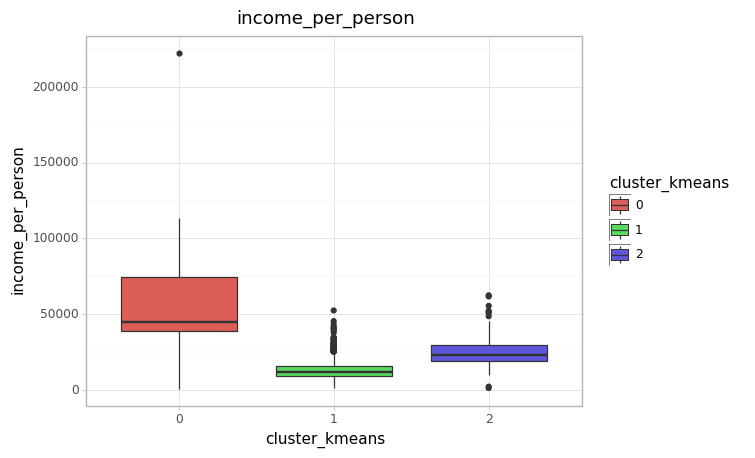

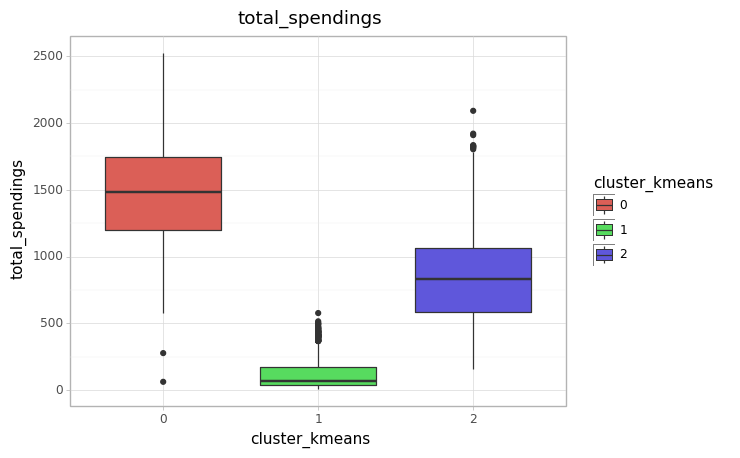

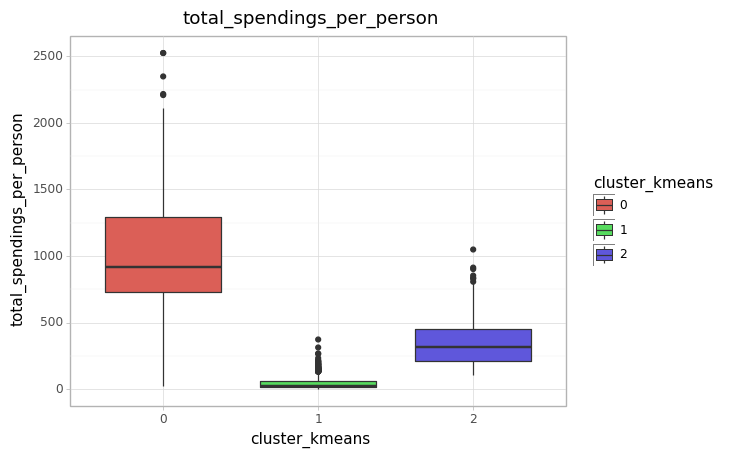

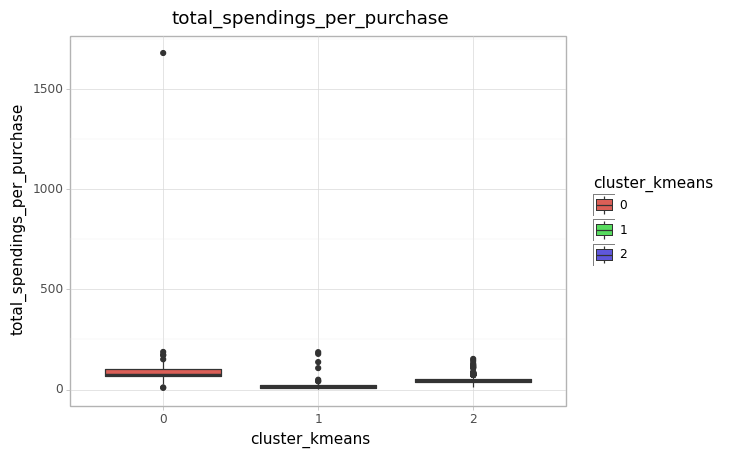

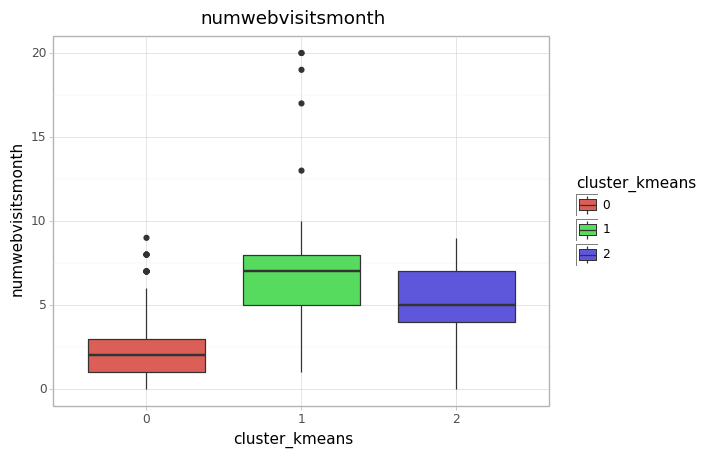

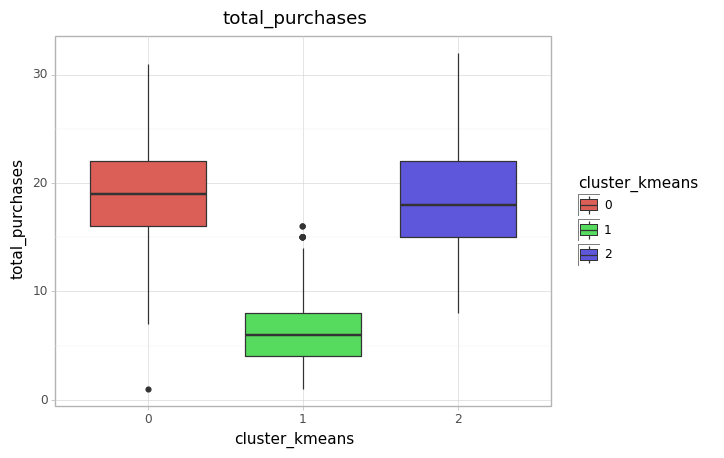

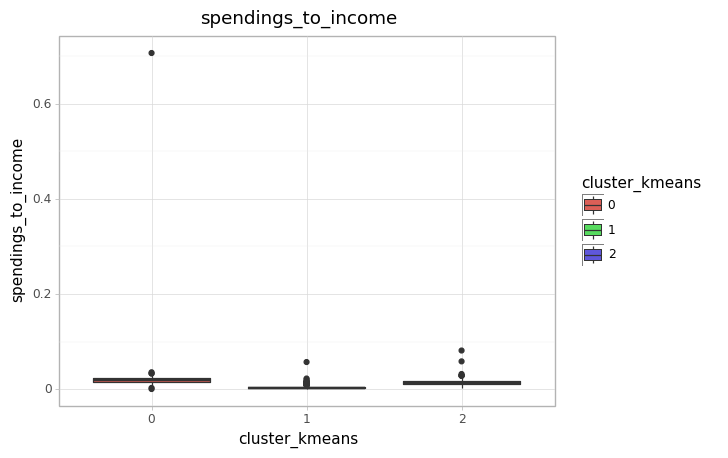

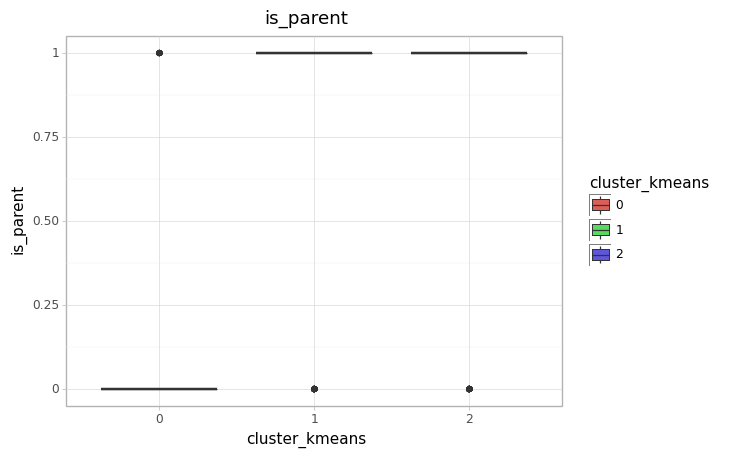

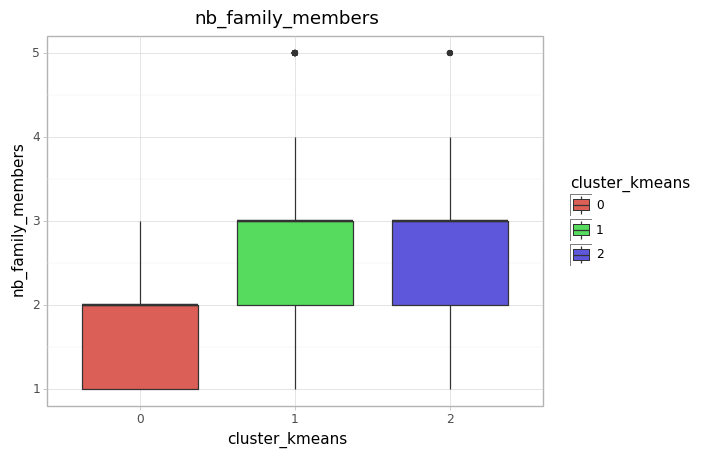

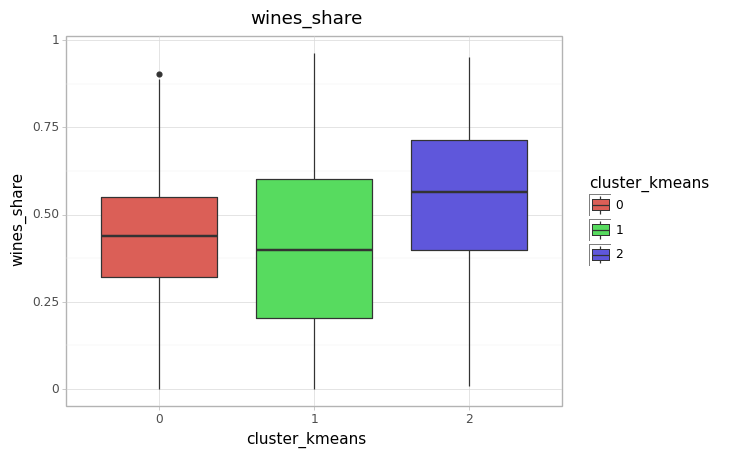

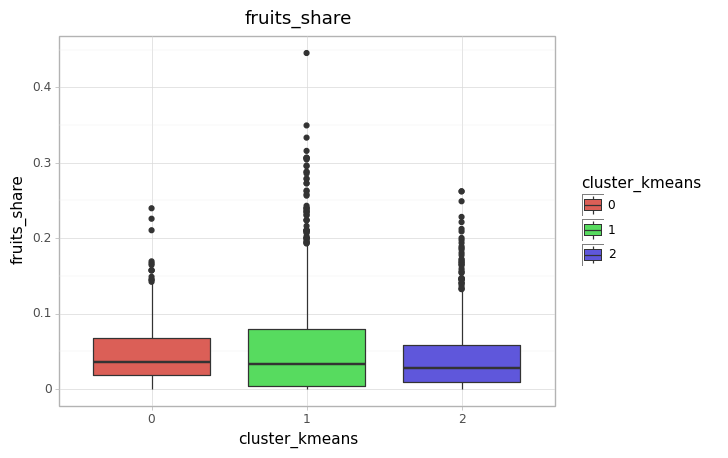

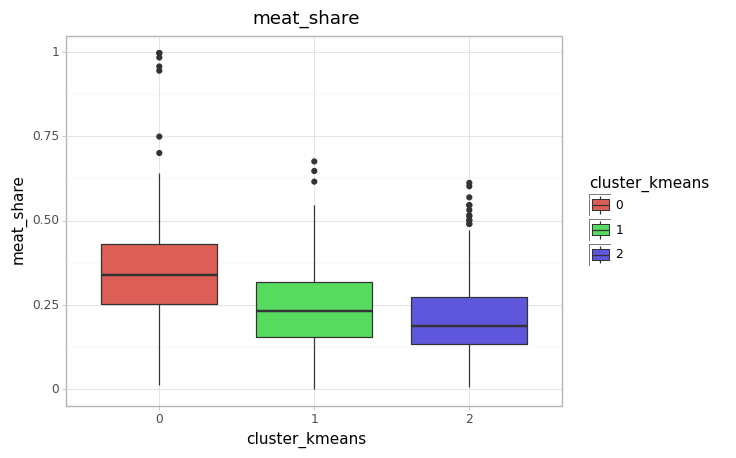

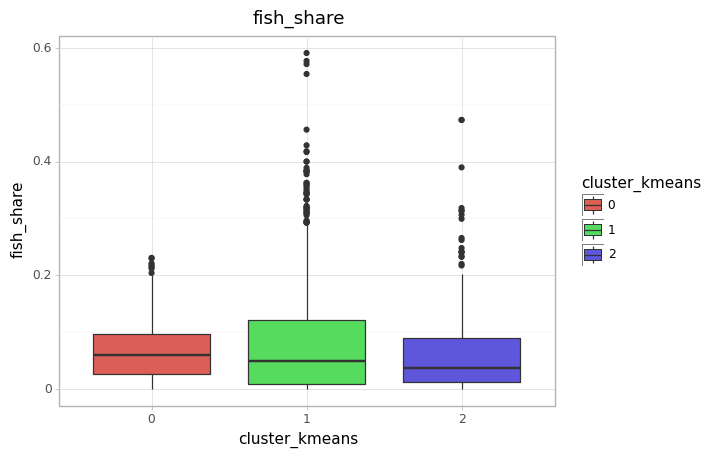

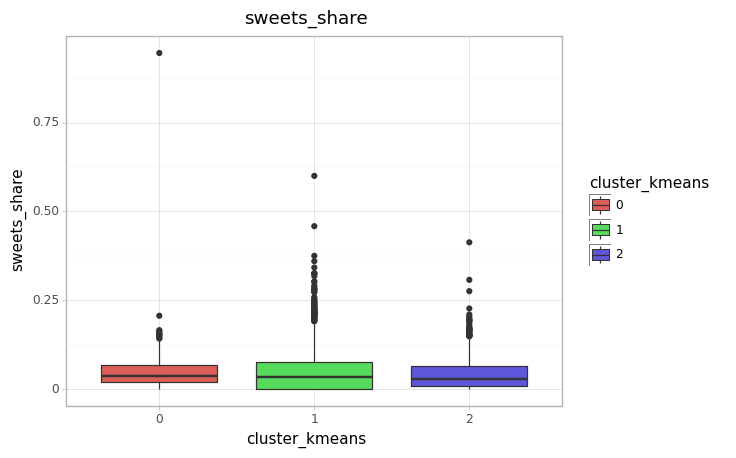

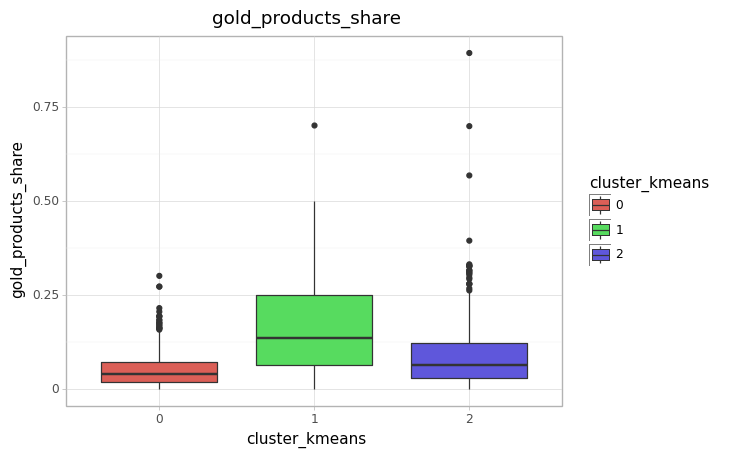

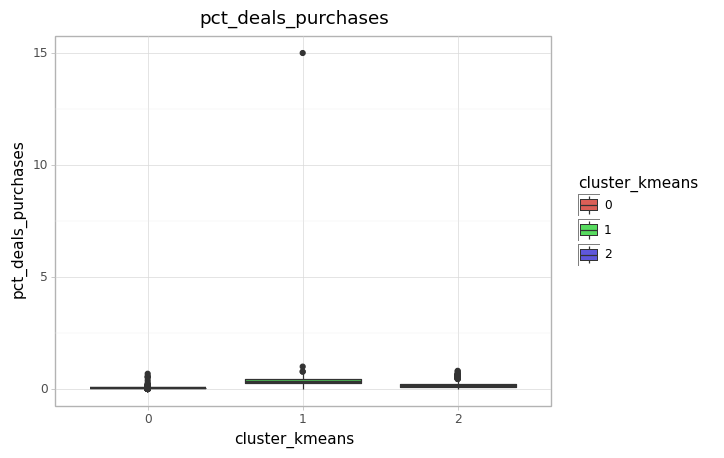

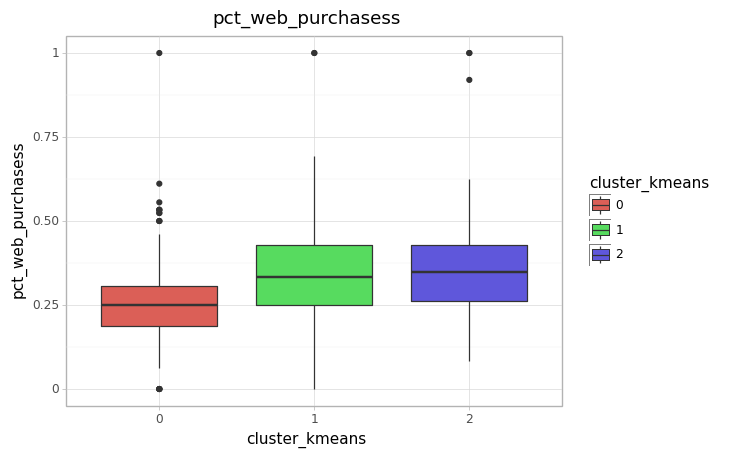

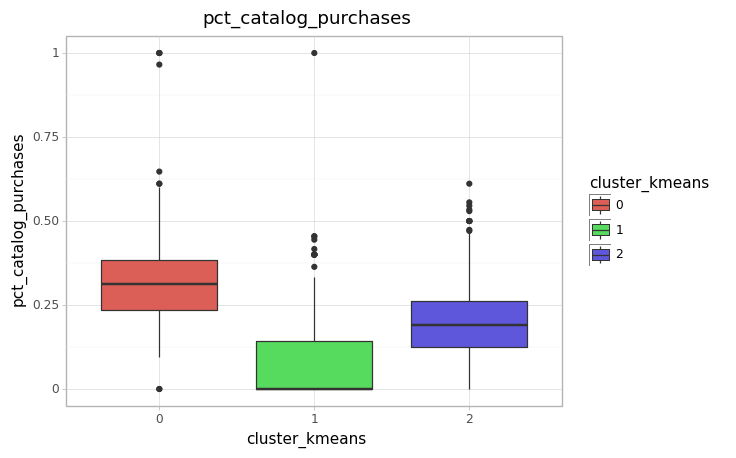

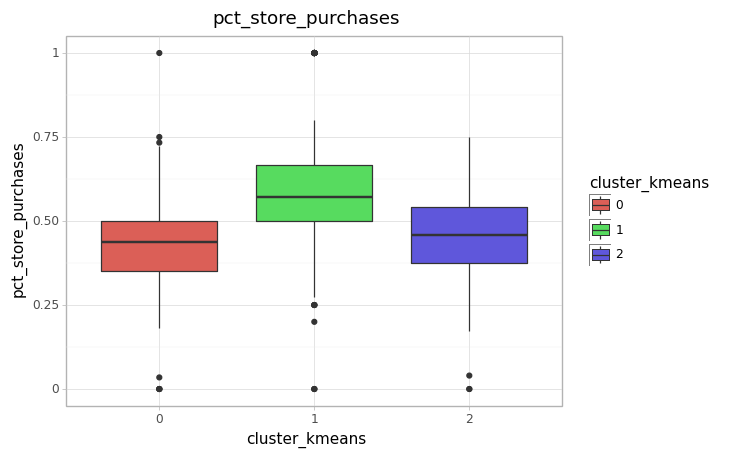

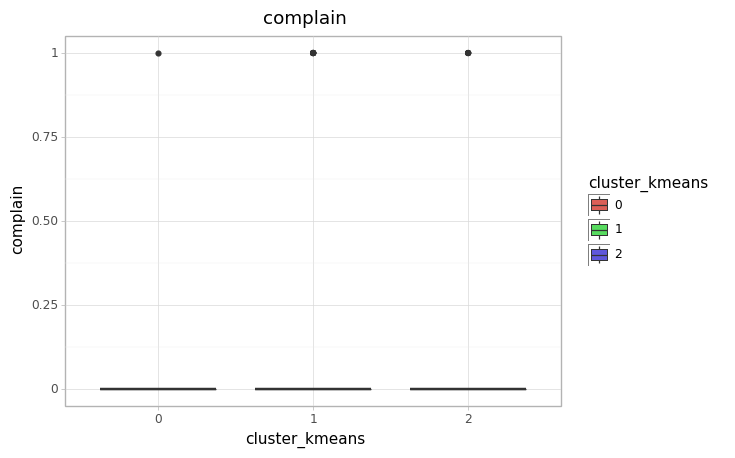

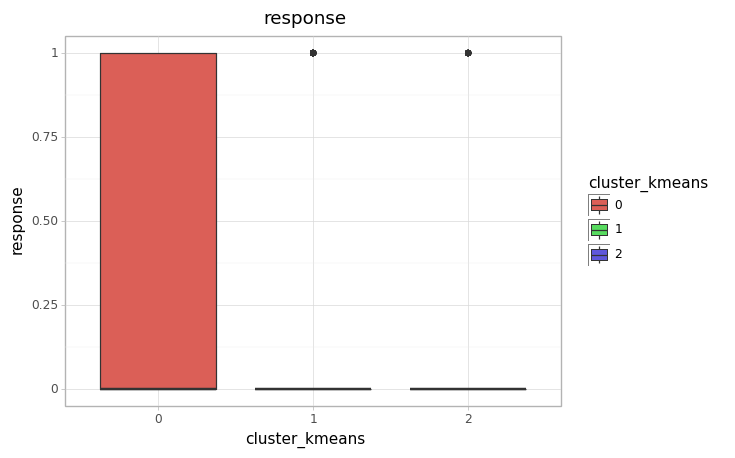

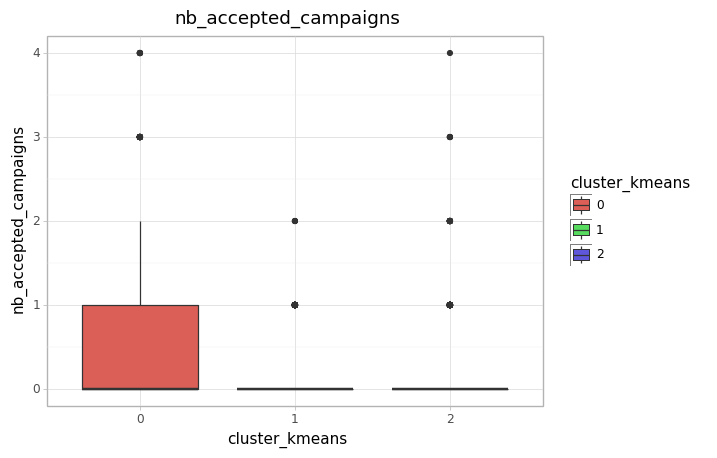

In [39]:
all_numeric_vars = num_features_to_scale + other_num_features

for col in all_numeric_vars:
    plot_boxplot_by_cluster(df, col, "cluster_kmeans")

Most important scatters with visible split by clusters

In [40]:
paired_vars = [('income_per_person', 'total_spendings_per_person'),
               ('income_per_person', 'total_purchases'),
               ('total_spendings_per_person', 'total_purchases')]

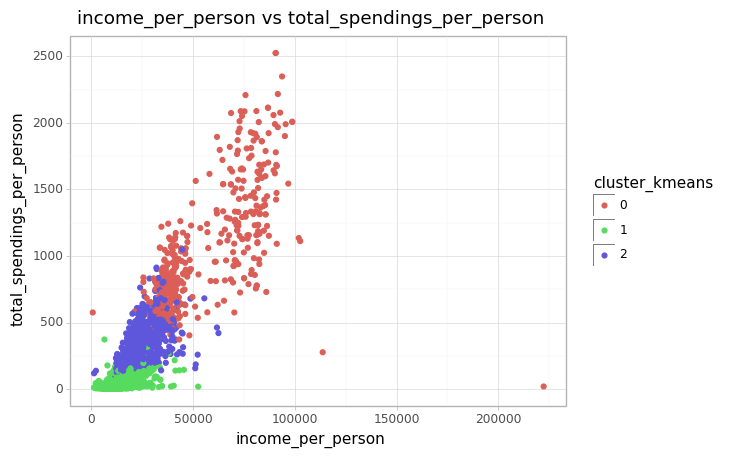

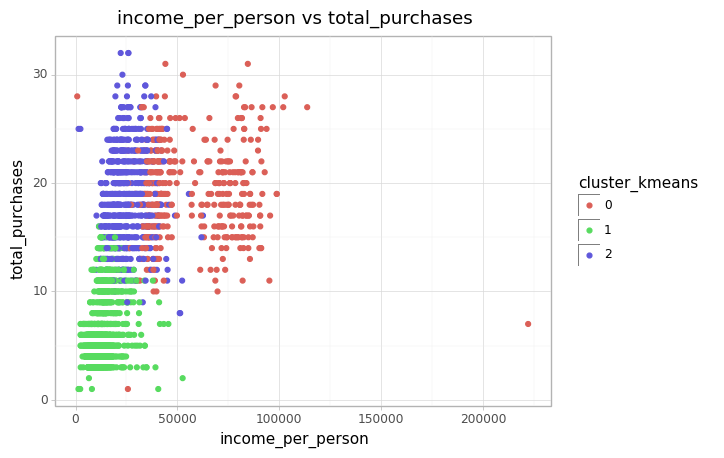

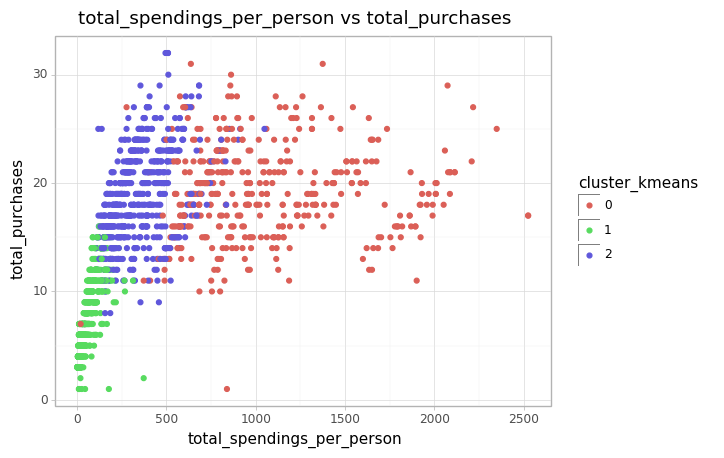

In [41]:
for pair in paired_vars:
    plot_scatter_by_cluster(df, pair[0], pair[1], "cluster_kmeans")